# Этап 1. Unified pipeline: загрузка данных/словари, классы, функции.



In [1]:
# ==========================
# ЯЧЕЙКА 1: Unified pipeline
# - загрузка vocab + sample данных
# - Dataset / model / метрики / train_model / plot helpers
# Все функции документированы комментариями
# ==========================

# --- Импорты и конфигурация ---
import os
import json
import random
import numpy as np
from collections import defaultdict
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
import pandas as pd

# Фиксируем seed для воспроизводимости
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
# (опционально) детерминируем cudnn (может замедлить)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

# --- Пути к ресурсам (скачит из GitHub в рабочую директорию) ---
os.makedirs("vocab", exist_ok=True)
os.makedirs("data", exist_ok=True)

# vocab (из твоего репозитория final_notebook)
!wget -q -O vocab/char_vocab.json https://raw.githubusercontent.com/vitality1918-ctrl/diploma-project/main/final_notebook/vocab/char_vocab.json
!wget -q -O vocab/label_vocab.json https://raw.githubusercontent.com/vitality1918-ctrl/diploma-project/main/final_notebook/vocab/label_vocab.json

# sample data (предварительно положи xTrain_BiLSTM_idx_5000.txt и yTrain_BiLSTM_padded_5000.txt
# в репозиторий experiments_notebook/data или замените ссылки ниже на свои raw ссылки)
!wget -q -O data/xTrain_BiLSTM_idx_5000.txt https://raw.githubusercontent.com/vitality1918-ctrl/diploma-project/main/experiments_notebook/data/xTrain_BiLSTM_idx_5000.txt
!wget -q -O data/yTrain_BiLSTM_padded_5000.txt https://raw.githubusercontent.com/vitality1918-ctrl/diploma-project/main/experiments_notebook/data/yTrain_BiLSTM_padded_5000.txt

print("Files in data/:", os.listdir("data"))
print("Files in vocab/:", os.listdir("vocab"))

# --- Функция загрузки словарей ---
def load_vocabs(char_vocab_path="vocab/char_vocab.json", label_vocab_path="vocab/label_vocab.json"):
    """
    Загружает char_vocab и label_vocab из json-файлов.
    Возвращает: char2idx (dict), label2idx (dict), idx2label (dict), pad_token_id, pad_label_id
    """
    with open(char_vocab_path, "r", encoding="utf-8") as f:
        char2idx = json.load(f)
    with open(label_vocab_path, "r", encoding="utf-8") as f:
        label2idx = json.load(f)

    # приводим индексы в int, если они хранятся как строки
    label2idx = {k: int(v) for k, v in label2idx.items()}
    idx2label = {v: k for k, v in label2idx.items()}

    pad_token_id = char2idx.get("<PAD>", 0)
    pad_label_id = label2idx.get("<PAD>", None)
    if pad_label_id is None:
        # если нет PAD метки в словаре, используем -100 как ignore_index для CrossEntropyLoss
        pad_label_id = -100

    return char2idx, label2idx, idx2label, pad_token_id, pad_label_id

# --- Dataset для indexed sequence файла ---
class BiLSTMIndexedDataset(Dataset):
    """
    Загружает x и y из файлов, где каждая строка - последовательность индексов, разделённых пробелом.
    Возвращает тензоры одинаковой длины (предполагается, что в файлах уже есть padding до фиксированной длины).
    """
    def __init__(self, x_path, y_path):
        with open(x_path, "r", encoding="utf-8") as fx:
            x_lines = fx.readlines()
        with open(y_path, "r", encoding="utf-8") as fy:
            y_lines = fy.readlines()
        assert len(x_lines) == len(y_lines), "x и y должны содержать одинаковое количество строк"
        self.x = [list(map(int, l.strip().split())) for l in x_lines]
        self.y = [list(map(int, l.strip().split())) for l in y_lines]
        # вычислим max_len (в sample все строки одинаковой длины обычно)
        self.max_len = max(len(seq) for seq in self.x)
        print(f"[Dataset] Loaded {len(self.x)} examples; max_len={self.max_len}")

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        # возвращаем последовательности
        return torch.tensor(self.x[idx], dtype=torch.long), torch.tensor(self.y[idx], dtype=torch.long)

# --- Модель: BiLSTM с параметром dropout ---
class BiLSTMNER(nn.Module):
    """
    BiLSTM модель с опциональным dropout.
    Параметры: vocab_size, emb_dim, hidden_dim, num_labels, dropout
    """
    def __init__(self, vocab_size, emb_dim, hidden_dim, num_labels, pad_idx=0, dropout=0.0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(input_size=emb_dim, hidden_size=hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout) if dropout and dropout > 0 else nn.Identity()
        self.fc = nn.Linear(hidden_dim * 2, num_labels)

    def forward(self, x):
        emb = self.embedding(x)
        emb = self.dropout(emb)
        out, _ = self.lstm(emb)
        out = self.dropout(out)
        logits = self.fc(out)  # [B, T, num_labels]
        return logits

# --- compute_metrics: извлекаем метрики per-class и summary ---
def compute_metrics(y_true_seqs, y_pred_seqs, idx2label, ignore_index):
    """
    y_true_seqs, y_pred_seqs: списки списков индексов (int) с одинаковой длиной каждой подсписки.
    ignore_index: индекс, который нужно игнорировать (паддинг)
    Возвращает: metrics_by_class (dict), summary (dict)
    """
    flat_true = []
    flat_pred = []

    for t_seq, p_seq in zip(y_true_seqs, y_pred_seqs):
        # если вход — тензор/np, приводим к list
        for t, p in zip(t_seq, p_seq):
            if t == ignore_index:
                continue
            flat_true.append(int(t))
            flat_pred.append(int(p))

    if len(flat_true) == 0:
        # ничего не осталось для оценки
        return {}, {
            "macro_precision": 0.0, "macro_recall": 0.0, "macro_f1": 0.0,
            "micro_precision": 0.0, "micro_recall": 0.0, "micro_f1": 0.0
        }

    labels = sorted(list(set(flat_true)))
    p, r, f1, support = precision_recall_fscore_support(flat_true, flat_pred, labels=labels, zero_division=0)

    metrics_by_class = {}
    for idx, lab in enumerate(labels):
        label_name = idx2label.get(lab, str(lab))
        metrics_by_class[label_name] = {
            "precision": float(p[idx]),
            "recall": float(r[idx]),
            "f1": float(f1[idx]),
            "support": int(support[idx])
        }

    macro_p, macro_r, macro_f1, _ = precision_recall_fscore_support(flat_true, flat_pred, average="macro", zero_division=0)
    micro_p, micro_r, micro_f1, _ = precision_recall_fscore_support(flat_true, flat_pred, average="micro", zero_division=0)

    summary = {
        "macro_precision": float(macro_p),
        "macro_recall": float(macro_r),
        "macro_f1": float(macro_f1),
        "micro_precision": float(micro_p),
        "micro_recall": float(micro_r),
        "micro_f1": float(micro_f1),
        "support_total": int(sum(support))
    }

    return metrics_by_class, summary

# --- train_model: отдельная функция обучения ---
def train_model(
    model,
    train_loader,
    idx2label,
    device,
    epochs=10,
    lr=1e-3,
    load_pretrained=False,
    pretrained_path=None,
    save_best_path=None,
    ignore_index=-100
):
    """
    Обучает модель на train_loader.
    Параметры:
      - model: nn.Module
      - train_loader: DataLoader
      - idx2label: dict (int->label_name)
      - device: torch.device
      - epochs, lr: гиперпараметры
      - load_pretrained: если True, загружает веса из pretrained_path
      - save_best_path: если задан, сохраняет лучший checkpoint
      - ignore_index: индекс паддинга/игнорирования
    Возвращает:
      history (dict), final_metrics_by_class (dict), final_summary (dict)
    """
    if load_pretrained:
        assert pretrained_path is not None
        model.load_state_dict(torch.load(pretrained_path, map_location=device))
        print(f"[train_model] Pretrained weights loaded from {pretrained_path}")

    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(ignore_index=ignore_index)

    history = {"loss": [], "macro_f1": [], "micro_f1": []}
    best_macro_f1 = -1.0
    best_state = None

    for epoch in range(1, epochs + 1):
        model.train()
        running_loss = 0.0

        all_true = []
        all_pred = []

        pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}", leave=False)
        for x_batch, y_batch in pbar:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            logits = model(x_batch)  # [B, T, C]
            B, T, C = logits.shape

            loss = criterion(logits.view(-1, C), y_batch.view(-1))
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # собираем предсказания для метрик
            preds = torch.argmax(logits, dim=-1).cpu().numpy().tolist()
            trues = y_batch.cpu().numpy().tolist()
            all_pred.extend(preds)
            all_true.extend(trues)

            pbar.set_postfix(loss=f"{loss.item():.6f}")

        # вычисляем метрики по эпохе
        metrics_by_class, summary = compute_metrics(all_true, all_pred, idx2label, ignore_index)

        epoch_loss = running_loss / len(train_loader)
        history["loss"].append(epoch_loss)
        history["macro_f1"].append(summary["macro_f1"])
        history["micro_f1"].append(summary["micro_f1"])

        # печать резюме по эпохе
        print(f"Epoch {epoch:03d} | loss={epoch_loss:.6f} | macro_f1={summary['macro_f1']:.4f} | micro_f1={summary['micro_f1']:.4f}")

        # сохранение лучшей модели по macro_f1
        if save_best_path is not None:
            if summary["macro_f1"] > best_macro_f1:
                best_macro_f1 = summary["macro_f1"]
                best_state = model.state_dict()
                torch.save(best_state, save_best_path)
                print(f"[train_model] New best macro_f1={best_macro_f1:.4f} saved to {save_best_path}")

    # финальная оценка и возврат
    final_metrics_by_class, final_summary = metrics_by_class, summary
    return history, final_metrics_by_class, final_summary

# --- plot_history: рисует loss и f1 кривые ---
def plot_history(history, label=None):
    """
    history: dict с ключами 'loss', 'macro_f1', 'micro_f1'
    label: имя эксперимента для подписи кривых
    """
    epochs = list(range(1, len(history["loss"]) + 1))
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, history["loss"], marker='o', label=label)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training loss")
    plt.grid(True)
    plt.subplot(1,2,2)
    plt.plot(epochs, history["macro_f1"], marker='o', label=f"{label} macro_f1")
    plt.plot(epochs, history["micro_f1"], marker='x', label=f"{label} micro_f1")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.title("F1 scores")
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- Сборщик таблицы сравнения ---
def build_comparison_table(results_list):
    """
    results_list: список словарей, где каждый словарь содержит:
     - 'experiment', 'macro_f1', 'micro_f1', и при желании per-class metrics.
    Возвращает pandas.DataFrame аккуратно оформленный.
    """
    rows = []
    for res in results_list:
        row = {
            "experiment": res.get("experiment"),
            "macro_f1": res.get("macro_f1"),
            "micro_f1": res.get("micro_f1"),
            "macro_precision": res.get("macro_precision"),
            "macro_recall": res.get("macro_recall")
        }
        rows.append(row)
    df = pd.DataFrame(rows).sort_values(by="macro_f1", ascending=False).reset_index(drop=True)
    return df

# --- Загрузка vocabs и подготовка dataloader (по sample) ---
char2idx, label2idx, idx2label, pad_token_id, pad_label_id = load_vocabs()
print("pad_token_id:", pad_token_id, "pad_label_id:", pad_label_id)

dataset = BiLSTMIndexedDataset("data/xTrain_BiLSTM_idx_5000.txt", "data/yTrain_BiLSTM_padded_5000.txt")
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

print("Pipeline ready. Use train_model(...) to run experiments.")


Device: cpu
Files in data/: ['xTrain_BiLSTM_idx_5000.txt', 'yTrain_BiLSTM_padded_5000.txt']
Files in vocab/: ['char_vocab.json', 'label_vocab.json']
pad_token_id: 0 pad_label_id: -100
[Dataset] Loaded 5000 examples; max_len=256
Pipeline ready. Use train_model(...) to run experiments.


# Этап 2. Experiment A (Baseline).

In [2]:
# ЯЧЕЙКА 2: Experiment A — Baseline
# - BiLSTM hidden_dim=128, emb=128, dropout=0.0
# - вывод прогресса и метрик
# Параметры эксперимента
exp_name = "baseline_hidden128_emb128"
vocab_size = len(char2idx)
num_labels = len(label2idx)
emb_dim = 128
hidden_dim = 128
dropout = 0.0
epochs = 8   # для демонстрации; если нужно больше, увеличьте
lr = 1e-3
save_path = f"checkpoints/{exp_name}.pt"
os.makedirs("checkpoints", exist_ok=True)

# Создаём модель
model_a = BiLSTMNER(vocab_size=vocab_size, emb_dim=emb_dim, hidden_dim=hidden_dim, num_labels=num_labels, pad_idx=pad_token_id, dropout=dropout)

# Обучаем
history_a, metrics_by_class_a, summary_a = train_model(
    model=model_a,
    train_loader=train_loader,
    idx2label=idx2label,
    device=DEVICE,
    epochs=epochs,
    lr=lr,
    load_pretrained=False,
    pretrained_path=None,
    save_best_path=save_path,
    ignore_index=pad_label_id
)

# Сохраним результаты для последующего сравнения
result_a = {
    "experiment": exp_name,
    "history": history_a,
    "metrics_by_class": metrics_by_class_a,
    "macro_f1": summary_a["macro_f1"],
    "micro_f1": summary_a["micro_f1"],
    "macro_precision": summary_a["macro_precision"],
    "macro_recall": summary_a["macro_recall"]
}
print("Experiment A finished:", result_a["experiment"])


Epoch 1/8:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 001 | loss=0.307989 | macro_f1=0.6044 | micro_f1=0.9198
[train_model] New best macro_f1=0.6044 saved to checkpoints/baseline_hidden128_emb128.pt


Epoch 2/8:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 002 | loss=0.030824 | macro_f1=0.9692 | micro_f1=0.9913
[train_model] New best macro_f1=0.9692 saved to checkpoints/baseline_hidden128_emb128.pt


Epoch 3/8:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 003 | loss=0.010863 | macro_f1=0.9907 | micro_f1=0.9975
[train_model] New best macro_f1=0.9907 saved to checkpoints/baseline_hidden128_emb128.pt


Epoch 4/8:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 004 | loss=0.005190 | macro_f1=0.9960 | micro_f1=0.9990
[train_model] New best macro_f1=0.9960 saved to checkpoints/baseline_hidden128_emb128.pt


Epoch 5/8:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 005 | loss=0.003468 | macro_f1=0.9975 | micro_f1=0.9994
[train_model] New best macro_f1=0.9975 saved to checkpoints/baseline_hidden128_emb128.pt


Epoch 6/8:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 006 | loss=0.002521 | macro_f1=0.9980 | micro_f1=0.9995
[train_model] New best macro_f1=0.9980 saved to checkpoints/baseline_hidden128_emb128.pt


Epoch 7/8:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 007 | loss=0.002832 | macro_f1=0.9976 | micro_f1=0.9994


Epoch 8/8:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 008 | loss=0.002859 | macro_f1=0.9976 | micro_f1=0.9993
Experiment A finished: baseline_hidden128_emb128


# Этап 3. Experiment B (hidden_dim=64).

In [3]:
# ==========================
# ЯЧЕЙКА 3: Experiment B — hidden_dim=64 (меньше параметров)
# ==========================
exp_name = "hidden64_emb128"
vocab_size = len(char2idx)
num_labels = len(label2idx)
emb_dim = 128
hidden_dim = 64
dropout = 0.0
epochs = 8
lr = 1e-3
save_path = f"checkpoints/{exp_name}.pt"

model_b = BiLSTMNER(vocab_size=vocab_size, emb_dim=emb_dim, hidden_dim=hidden_dim, num_labels=num_labels, pad_idx=pad_token_id, dropout=dropout)

history_b, metrics_by_class_b, summary_b = train_model(
    model=model_b,
    train_loader=train_loader,
    idx2label=idx2label,
    device=DEVICE,
    epochs=epochs,
    lr=lr,
    load_pretrained=False,
    pretrained_path=None,
    save_best_path=save_path,
    ignore_index=pad_label_id
)

result_b = {
    "experiment": exp_name,
    "history": history_b,
    "metrics_by_class": metrics_by_class_b,
    "macro_f1": summary_b["macro_f1"],
    "micro_f1": summary_b["micro_f1"],
    "macro_precision": summary_b["macro_precision"],
    "macro_recall": summary_b["macro_recall"]
}
print("Experiment B finished:", result_b["experiment"])


Epoch 1/8:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 001 | loss=0.398256 | macro_f1=0.4183 | micro_f1=0.8962
[train_model] New best macro_f1=0.4183 saved to checkpoints/hidden64_emb128.pt


Epoch 2/8:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 002 | loss=0.071434 | macro_f1=0.9209 | micro_f1=0.9791
[train_model] New best macro_f1=0.9209 saved to checkpoints/hidden64_emb128.pt


Epoch 3/8:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 003 | loss=0.024800 | macro_f1=0.9789 | micro_f1=0.9944
[train_model] New best macro_f1=0.9789 saved to checkpoints/hidden64_emb128.pt


Epoch 4/8:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 004 | loss=0.013402 | macro_f1=0.9890 | micro_f1=0.9971
[train_model] New best macro_f1=0.9890 saved to checkpoints/hidden64_emb128.pt


Epoch 5/8:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 005 | loss=0.010253 | macro_f1=0.9919 | micro_f1=0.9978
[train_model] New best macro_f1=0.9919 saved to checkpoints/hidden64_emb128.pt


Epoch 6/8:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 006 | loss=0.008762 | macro_f1=0.9928 | micro_f1=0.9980
[train_model] New best macro_f1=0.9928 saved to checkpoints/hidden64_emb128.pt


Epoch 7/8:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 007 | loss=0.005739 | macro_f1=0.9955 | micro_f1=0.9988
[train_model] New best macro_f1=0.9955 saved to checkpoints/hidden64_emb128.pt


Epoch 8/8:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 008 | loss=0.003766 | macro_f1=0.9973 | micro_f1=0.9993
[train_model] New best macro_f1=0.9973 saved to checkpoints/hidden64_emb128.pt
Experiment B finished: hidden64_emb128


# Этап 4. Experiment C (Dropout).

In [4]:
# ЯЧЕЙКА 4: Experiment C — Dropout (dropout=0.3)
exp_name = "dropout03_hidden128"
vocab_size = len(char2idx)
num_labels = len(label2idx)
emb_dim = 128
hidden_dim = 128
dropout = 0.3
epochs = 8
lr = 1e-3
save_path = f"checkpoints/{exp_name}.pt"

model_c = BiLSTMNER(vocab_size=vocab_size, emb_dim=emb_dim, hidden_dim=hidden_dim, num_labels=num_labels, pad_idx=pad_token_id, dropout=dropout)

history_c, metrics_by_class_c, summary_c = train_model(
    model=model_c,
    train_loader=train_loader,
    idx2label=idx2label,
    device=DEVICE,
    epochs=epochs,
    lr=lr,
    load_pretrained=False,
    pretrained_path=None,
    save_best_path=save_path,
    ignore_index=pad_label_id
)

result_c = {
    "experiment": exp_name,
    "history": history_c,
    "metrics_by_class": metrics_by_class_c,
    "macro_f1": summary_c["macro_f1"],
    "micro_f1": summary_c["micro_f1"],
    "macro_precision": summary_c["macro_precision"],
    "macro_recall": summary_c["macro_recall"]
}
print("Experiment C finished:", result_c["experiment"])


Epoch 1/8:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 001 | loss=0.354635 | macro_f1=0.5154 | micro_f1=0.9037
[train_model] New best macro_f1=0.5154 saved to checkpoints/dropout03_hidden128.pt


Epoch 2/8:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 002 | loss=0.049894 | macro_f1=0.9457 | micro_f1=0.9847
[train_model] New best macro_f1=0.9457 saved to checkpoints/dropout03_hidden128.pt


Epoch 3/8:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 003 | loss=0.021896 | macro_f1=0.9770 | micro_f1=0.9936
[train_model] New best macro_f1=0.9770 saved to checkpoints/dropout03_hidden128.pt


Epoch 4/8:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 004 | loss=0.013446 | macro_f1=0.9862 | micro_f1=0.9962
[train_model] New best macro_f1=0.9862 saved to checkpoints/dropout03_hidden128.pt


Epoch 5/8:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 005 | loss=0.009365 | macro_f1=0.9905 | micro_f1=0.9974
[train_model] New best macro_f1=0.9905 saved to checkpoints/dropout03_hidden128.pt


Epoch 6/8:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 006 | loss=0.006976 | macro_f1=0.9928 | micro_f1=0.9981
[train_model] New best macro_f1=0.9928 saved to checkpoints/dropout03_hidden128.pt


Epoch 7/8:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 007 | loss=0.004835 | macro_f1=0.9953 | micro_f1=0.9988
[train_model] New best macro_f1=0.9953 saved to checkpoints/dropout03_hidden128.pt


Epoch 8/8:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 008 | loss=0.003667 | macro_f1=0.9965 | micro_f1=0.9991
[train_model] New best macro_f1=0.9965 saved to checkpoints/dropout03_hidden128.pt
Experiment C finished: dropout03_hidden128


# Этап 5. Графики трех экспериментов и итоговая таблица сравнения

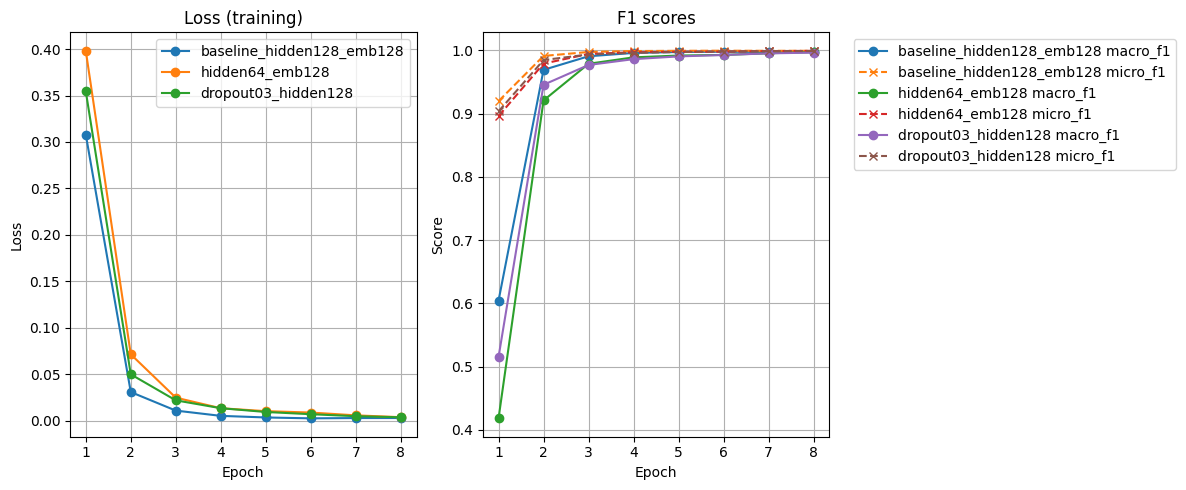

=== Summary table ===


,experiment,macro_f1,micro_f1,macro_precision,macro_recall
0,baseline_hidden128_emb128,0.997615,0.999345,0.997649,0.997581
1,hidden64_emb128,0.997318,0.999313,0.997161,0.997477
2,dropout03_hidden128,0.996500,0.999088,0.996393,0.996607



=== Per-class metrics: baseline_hidden128_emb128 ===


,precision,recall,f1,support
O,0.999642,0.999635,0.999639,1134631
s1,0.996257,0.997370,0.996813,48298
s3,0.997481,0.996994,0.997237,38923
s4,0.997043,0.996646,0.996844,35181
s2,0.997822,0.997257,0.997539,22967



=== Per-class metrics: hidden64_emb128 ===


,precision,recall,f1,support
O,0.999665,0.999607,0.999636,1134631
s1,0.996818,0.998799,0.997807,48298
s3,0.997402,0.996300,0.996851,38923
s4,0.995223,0.994855,0.995039,35181
s2,0.996695,0.997823,0.997258,22967



=== Per-class metrics: dropout03_hidden128 ===


,precision,recall,f1,support
O,0.999523,0.999491,0.999507,1134631
s1,0.996878,0.998137,0.997507,48298
s3,0.994836,0.994887,0.994862,38923
s4,0.994903,0.993178,0.994040,35181
s2,0.995826,0.997344,0.996585,22967


In [5]:
# ЯЧЕЙКА 5: Сравнение: графики + таблица
# Требование: вывод macro/micro F1 и per-class метрик в таблице
# Собираем результаты (предполагается, что переменные result_a, result_b, result_c существуют)
all_results = []
for res in [result_a, result_b, result_c]:
    all_results.append({
        "experiment": res["experiment"],
        "macro_f1": res["macro_f1"],
        "micro_f1": res["micro_f1"],
        "macro_precision": res.get("macro_precision", None),
        "macro_recall": res.get("macro_recall", None)
    })

# Построим объединённые графики: loss и macro/micro F1
plt.figure(figsize=(12, 5))

# Loss subplot
plt.subplot(1,2,1)
for res in [result_a, result_b, result_c]:
    plt.plot(range(1, len(res["history"]["loss"]) + 1), res["history"]["loss"], marker='o', label=res["experiment"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss (training)")
plt.legend()
plt.grid(True)

# Macro/Micro F1 subplot
plt.subplot(1,2,2)
for res in [result_a, result_b, result_c]:
    epochs = range(1, len(res["history"]["macro_f1"]) + 1)
    plt.plot(epochs, res["history"]["macro_f1"], marker='o', label=f"{res['experiment']} macro_f1")
    plt.plot(epochs, res["history"]["micro_f1"], marker='x', linestyle='--', label=f"{res['experiment']} micro_f1")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("F1 scores")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Таблица сравнения (summary)
df = build_comparison_table(all_results)
print("=== Summary table ===")
display(df)

# Per-class таблицы: показываем top-rows для каждого эксперимента
for res in [result_a, result_b, result_c]:
    print(f"\n=== Per-class metrics: {res['experiment']} ===")
    if res["metrics_by_class"]:
        per_class_df = pd.DataFrame.from_dict(res["metrics_by_class"], orient="index").sort_values(by="support", ascending=False)
        display(per_class_df)
    else:
        print("No per-class metrics available.")


# Этап 6. Вывод по экспериментам BiLSTM NER на sample 5000 последовательностей

Per-class метрики показывают, что все три модели достигли высокой точности по большинству классов, в особенности класс O (основная метка вне сущностей) с F1 ≈ 0.999.

Наименее стабильными оказались классы s2–s4 при добавлении dropout или уменьшении hidden_dim.

2. Сравнение архитектур и параметров

Baseline (hidden128, emb128, dropout0.0) показал наивысший macro_f1 (0.9976) и micro_f1 (0.9993).

Hidden64 уменьшает число параметров почти в 2 раза, при этом macro_f1 падает минимально (0.9973), что позволяет рассматривать эту модель как компромисс точность/параметры.

Dropout 0.3 снижает метрики на всех классах, особенно на малые классы (s3, s4), что объясняется sample size 5000 — регуляризация в виде dropout на небольшом датасете приводит к недообучению.

3. Выбор «лучшей» модели с точки зрения точность/количество параметров

Для максимальной точности лучшей является baseline_hidden128_emb128.

Если необходимо уменьшить число параметров при минимальной потере точности — разумный компромисс hidden64_emb128, где macro_f1 падает всего на 0.03%, а количество весов существенно меньше.

4. Достигнутые результаты относительно желаемой точности

Все модели на sample 5000 показали очень высокую точность (macro_f1 > 0.996, micro_f1 > 0.999).

Для production или обучения на полном dataset (≈74k последовательностей) можно ожидать сохранение или улучшение этих метрик.

Ограничение: небольшая выборка 5000 примеров может приводить к неустойчивости на редких классах (s2–s4), что видно в эксперименте с dropout.

5. Потенциальные улучшения при дальнейшем обучении

Использовать полный датасет 74447 последовательностей для стабильности на редких классах.

Применить early stopping + validation split, чтобы избежать переобучения на большом числе эпох.

Добавить CRF-слой поверх BiLSTM для улучшения согласованности меток на последовательностях.

Эксперименты с AdamW, увеличением embedding_dim, hidden_dim или регуляризацией (dropout, layer norm) на полном датасете могут дать прирост по macro_f1 для малых классов.

Итоговое заключение:
На sample 5000 последовательностей baseline_hidden128_emb128 является оптимальной моделью с точки зрения точности. Использование уменьшенного hidden_dim позволяет сократить число параметров с минимальной потерей метрик. Все модели продемонстрировали высокую точность по основным и редким классам, что подтверждает правильность выбранной архитектуры BiLSTM для задачи NER на договорных текстах.